In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, os
import matplotlib as mpl
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, 
                             precision_score,
                             recall_score, f1_score)

Functions

In [2]:
def get_WOEs(X, y, decimal=4, verbose=False):
    str_fmt = "{}: P(bad) = {:.2%}, P(good) = {:.2%} >> WOE = {:,.2f}"
    WOE = X.copy()
    mapping = dict()
    N = np.r_[sum(y==0), sum(y)]
    for var in WOE.columns:
        x = WOE[var].values.copy()
        dok = {0:0, 1:0}
        for v in np.unique(x):  
            if v==1:
                n = np.array([sum(y[x==v]==m) for m in [0,1]])
                dist_good = np.fmax(n[0],1)/N[0]
                dist_bad  = np.fmax(n[1],1)/N[1]
                woe = np.log(dist_good/dist_bad)*100
                if verbose:
                    print(str_fmt.format(var, dist_bad, dist_good, woe))
                dok.update({1:np.round(woe, decimal)})        
        WOE[var] = WOE[var].apply(lambda x: dok[x])
        mapping.update({var:dok})
    print("Complete . . .")
    return WOE, mapping

In [3]:
def map_WOEs(X, mapping):
    WOE = X.copy()
    for var in WOE.columns:
        WOE[var] = WOE[var].apply(lambda x:mapping[var][x])
    return WOE

In [4]:
def prec_recall(y_true, y_pred0, y_pred1):
    def fmt(x):
        x = '{:.2%}'.format(x)
        return str(x).rjust(max(len(x),7), " ")
    p0 = fmt(precision_score(y_true, y_pred0))
    p1 = fmt(precision_score(y_true, y_pred1))
    r0 = fmt(recall_score(y_true, y_pred0))
    r1 = fmt(recall_score(y_true, y_pred1))
    print('Precision => Before : {} , After : {}'.format(p0,p1))
    print('Recall    => Before : {} , After : {}'.format(r0,r1))

In [5]:
def plot_score(y_true, scores, n_bins=20, cutoff=None, recall_const=0.):
    
    bins = np.linspace(min(scores), max(scores)+1, 
                       n_bins+1).astype(int)
    width = np.diff(bins)[0]
    axes = plt.subplots(2,2, figsize=(10.5,6))[1].ravel()
    colors = ["#1B9CFC","#FC427B"]
    labels = ["Normal = {:,d} ({:.2%})".format, 
              "Fraud = {:,d} ({:.2%})".format]
    
    for n,i in enumerate([0,2]):
        height = np.histogram(scores[y_true==n], bins)[0]
        axes[i].bar(bins[:-1], height/sum(height), 
                    width=width*0.8, color=colors[n], alpha=0.8)
        axes[i].set_xlabel("Score", fontsize=12)
        axes[i].set_ylabel("Density", fontsize=12)
        t = min(int(len(bins[:-1])/1.5),11)
        t = mpl.ticker.MaxNLocator(t)
        axes[i].xaxis.set_major_locator(t)
        axes[i].yaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
        axes[i].set_title(labels[n](sum(height),
                                    sum(height)/len(b)), fontsize=12)
    
    N1 = sum(y_true)
    unq_scores, unq_cnt = np.unique(scores, return_counts=True)
    pre = np.zeros(len(unq_scores))
    rec = np.zeros(len(unq_scores))
    for n,c in enumerate(np.unique(scores)):
        pre[n] = y_true[scores>=c].mean()
        rec[n] = y_true[scores>=c].sum()/N1
    denom = np.where(pre+rec==0,1,pre+rec)
    f1s = (2*pre*rec)/denom

    if cutoff is None: 
        k = np.argmax(np.where(rec<recall_const,0,f1s))
        cutoff = unq_scores[k]
    else: 
        cutoff = np.clip(cutoff, min(scores), max(scores))
        k = sum(unq_scores<cutoff)
        
    axes[1].plot(unq_scores, pre, lw=2, 
                 label="Precision ({:,.2%})".format(pre[k]))
    axes[1].plot(unq_scores, rec, lw=2, 
                 label="Recall ({:,.2%})".format(rec[k]))
    axes[1].plot(unq_scores, f1s, lw=2, 
                 label="F1 ({:,.2%})".format(f1s[k]))
    axes[1].set_xlabel("Score", fontsize=12)
    axes[1].set_ylabel("Scores", fontsize=12)
    axes[1].xaxis.set_major_locator(t)
    axes[1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
    axes[1].axvline(cutoff, lw=1, ls="--", color="grey", 
                    label= r"Cutoff $\geq$ {:,d}".format(cutoff))
    axes[1].legend(loc="best", fontsize=11) 
    
    labels = ["Normal ({:,.2%})".format, 
              "Fraud ({:,.2%})".format]
    for i in range(2):
        p = ((scores>=cutoff) & (y_true==i)).sum()/sum(y_true==i)
        unq_scores0, unq_cnt0 = np.unique(scores[y_true==i], 
                                          return_counts=True)
        cumd0 = np.cumsum(unq_cnt0[::-1])/sum(unq_cnt0)
        cumd0 = np.where(cumd0==0,np.nan, cumd0)
        axes[3].plot(unq_scores0[::-1], cumd0, lw=2, 
                     zorder=i, color=colors[i], 
                     label=labels[i](p))
    
    cumd = np.cumsum(unq_cnt[::-1])/sum(unq_cnt)
    cumd = np.where(cumd==0,np.nan, cumd)
    y = float(cumd[::-1][np.argmax(unq_scores>=cutoff)])
    axes[3].plot(unq_scores[::-1], cumd, lw=2, zorder=-1, 
                 label="App ({:,.2%})".format(y), color="k")
    
    axes[3].set_xlabel("score", fontsize=12)
    axes[3].set_ylabel("Cumulative Density", fontsize=12)
    axes[3].xaxis.set_major_locator(t)
    axes[3].axvline(cutoff, lw=1, ls="--", color="grey")
    axes[3].axhline(y, lw=1, ls="--", color="grey")
    axes[3].set_title(r"Audit = {:.0%}, $\Delta$ = {:-.0%} "
                      .format(y,y-1), fontsize=12)
    axes[3].legend(loc="best", fontsize=11)

    for i in range(4):
        for s in ["top","right"]:
            axes[i].spines[s].set_visible(False)
    plt.tight_layout()
    plt.show()

In [6]:
def plot_results(x, y1, ylabel, labels, train_mth, y2=None):
    ax = plt.subplots(figsize=(10, 3.5))[1]
    ax.plot(x, y1, lw=3,  
            label=labels[0], solid_capstyle='round')
    if y2 is not None:
        ax.plot(x, y2, lw=3, 
                label=labels[1], solid_capstyle='round')
    set_prop(ax, x, ylabel, train_mth)
    plt.tight_layout()
    return ax

In [7]:
def set_prop(ax, x, ylabel, train_mth):
    
    '''set other ax properties'''
    for s in ["top","right"]: ax.spines[s].set_visible(False)
    
    # set x-axis properties
    x_min = min(x) - pd.Timedelta(days=32)
    x_max = max(x) + pd.Timedelta(days=32)
    ax.set_xlim(x_min, x_max)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(3,6,9,12)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=0, ha='center', fontsize=11)
    
    # set y-axis properties
    y_min, y_max = ax.get_ylim()
    y_max = y_max+(y_max-y_min)*0.15
    ax.set_ylim(y_min, y_max)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(8))
    ax.set_facecolor('white')
    ax.patch.set_alpha(0)
    
    # Train-test and Out-Of-Time periods
    xval = x[train_mth-1] + pd.Timedelta(days=15)
    ax.axvline(xval, lw=1, ls="--", color="grey")
    text ="In-Time\n{:,d} month(s)".format(train_mth)
    ax.annotate(text, (xval, y_max), textcoords='offset points', 
                va="top", ha="right", fontsize=11, xytext=(-5,0))
    text ="Out-Of-Time\n{:,d} month(s)".format(len(x)-train_mth)
    ax.annotate(text, (xval, y_max), textcoords='offset points', 
                va="top", ha="left", fontsize=11, xytext=(+5,0))
    legend = ax.legend(loc="upper left", fontsize=12, framealpha=0) 
    legend.set_bbox_to_anchor([1,1], transform=ax.transAxes)
    return ax

In [8]:
os.listdir()

['.ipynb_checkpoints',
 'assoc_rules_data_cut_to_75rules.7z',
 'assoc_rules_data_cut_to_75rules.txt',
 'Debit_Score_woe_r0.1.ipynb',
 'Debit_Score_woe_r0.ipynb',
 'Debit_Score_woe_r1.ipynb',
 'model_validation-main',
 'model_validation.py',
 'model_validation_colab.ipynb',
 'Rule_Validation_Debit_card 20221011 v3 (1).pptx',
 'ScoreAllocation_LR.ipynb',
 'ScoreAllocation_LR1.ipynb',
 'ScoreAllocation_RF.ipynb',
 'TreeExplainer.py',
 'TreeExplainer_colab.ipynb',
 '__pycache__']

In [61]:
df = pd.read_csv("assoc_rules_data_cut_to_75rules_asof_202209.txt", sep="|")
rules = list(set(list(df)).difference(['f_fraud','month_id','data_split']))

In [62]:
df.head()

,f_fraud,month_id,data_split,ATM0001,ATM0002.2,ATM0004,ATM0006,ATM0008,ATM0010,ATM0060,...,EDC0102.2,PGW0012.6_Debit,PGW0012.6_Debit_Reject,PGW0031.2,PGW0032.2,PGW0034.2,PGW0049.2,VVIP_Broad_001.2,VVIP_Broad_002.2,WLST0013.2
0,0,2020-10,train_test,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2020-10,train_test,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2020-10,train_test,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2020-11,train_test,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2020-11,train_test,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
df["month_id"].unique()

array(['2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03',
       '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10'], dtype=object)

Split train and test datasets

In [64]:
X = df.loc[df["data_split"]=='train_test', rules].copy()
y = df.loc[df["data_split"]=='train_test', 'f_fraud'].copy()

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X[rules], y, test_size=0.3, random_state=0)

In [66]:
X_oot = df.loc[df["data_split"]=='out_of_time', rules].copy()
y_oot = df.loc[df["data_split"]=='out_of_time', 'f_fraud'].copy()

Weight of Evidence (WOE)

In [67]:
woe_train, mapping = get_WOEs(X_train, y_train, verbose=False)

Complete . . .


In [68]:
woe_test = map_WOEs(X_test, mapping)
woe_oot  = map_WOEs(X_oot, mapping)

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(woe_train)
columns = list(woe_train)

In [70]:
woe_train = pd.DataFrame(scaler.transform(woe_train), columns=columns)
woe_test = pd.DataFrame(scaler.transform(woe_test), columns=columns)
woe_oot = pd.DataFrame(scaler.transform(woe_oot), columns=columns)

Running model (LogisticRegression)

In [71]:
kwds = dict(max_iter=1000, class_weight="balanced", 
            fit_intercept=False, random_state=0, solver= "liblinear")
model = LogisticRegression(**kwds)
model.fit(woe_train, y_train)

LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=1000,
                   random_state=0, solver='liblinear')

In [72]:
used_features = list(woe_train)

In [73]:
model.coef_.ravel()

array([-9.11286429e-03, -8.82505925e-01, -1.02157393e-01, -1.35225302e-02,
       -5.36643280e-02, -1.61932073e-02,  2.32235021e-02,  0.00000000e+00,
        9.29728082e-04,  2.61694708e-02,  4.74125818e-02,  2.89785013e-02,
       -1.97009558e-02, -1.69845575e-02,  4.49315358e-02, -3.38347323e-02,
       -3.85025888e-04, -1.41355196e-01, -2.08675935e-02,  0.00000000e+00,
       -2.15943533e-01,  8.97408685e-04,  2.17859335e-02,  1.61033183e-03,
        0.00000000e+00, -6.33179395e-02,  3.52703785e-02,  0.00000000e+00,
        0.00000000e+00,  3.33905383e-02, -2.05812452e-02,  5.82466487e-02,
        0.00000000e+00, -8.38102699e-03, -5.41102891e-02,  4.87567350e-02,
       -1.02924015e-01,  2.69336378e-03,  9.29728082e-04, -5.34911272e-03,
       -1.56773228e-02, -2.91983667e-02,  5.09212664e-03,  1.31483225e-03,
       -2.11916506e-02, -9.34018189e-02, -1.14606576e-03,  1.21019753e-01,
        0.00000000e+00, -1.24608260e-01, -1.31107242e-02,  0.00000000e+00,
       -6.62699260e-02,  

Predictions

In [74]:
y_train_pred = model.predict_proba(woe_train[used_features])[:,1]
y_test_pred = model.predict_proba(woe_test[used_features])[:,1]
y_oot_pred = model.predict_proba(woe_oot[used_features])[:,1]

Observe model performance

In [75]:
t = 0.8
print("="*48)
print("(1) Train")
prec_recall(y_train, X_train.sum(1)>0, y_train_pred>=t)
print("-"*48)
print("(2) Test")
prec_recall(y_test, X_test.sum(1)>0, y_test_pred>=t)
print("-"*48)
print("(3) Out-Of-Time")
prec_recall(y_oot, X_oot.sum(1)>0, y_oot_pred>=t)
print("="*48)

(1) Train
Precision => Before :   1.88% , After :   9.45%
Recall    => Before : 100.00% , After :  75.83%
------------------------------------------------
(2) Test
Precision => Before :   1.83% , After :   9.32%
Recall    => Before : 100.00% , After :  75.43%
------------------------------------------------
(3) Out-Of-Time
Precision => Before :   6.62% , After :  21.64%
Recall    => Before : 100.00% , After :  88.80%


## Score
$S = C + \sum_{i}^{N} (\beta_{i}W_{i}[f=1]).K$

- $W$ = Weight of Evidence = $\log(odd[f=1])$
- $C$ = Offset
- $N$ = Number of features
- $K$ = Scale factor (10)
- $f$ = {1: triggered, 0: not triggered)

In [172]:
score_dict = dict()
for f,coef in zip(used_features, model.coef_.ravel()):
    s = mapping[f][1] * coef
    # log transformation
    score_dict[f] = round((np.sign(s) * np.log(abs(s)+1) * 10))
#     score_dict[f] = round((mapping[f][1] * coef * 10))
scores = np.r_[[score_dict[c] for c in used_features]]
offset = -sum(scores[scores<0])
print("Offset = {:,d}".format(offset))

Offset = 331


In [173]:
offset = 0

In [174]:
s_min = offset + sum(scores[scores< 0])
s_max = offset + sum(scores[scores>=0])
print("Range : {:,d} <= Score <= {:,d}".format(s_min, s_max))

Range : -331 <= Score <= 521


In [175]:
pd.DataFrame(list(score_dict.items()),columns=["feature","score"])\
.sort_values(by="score", ascending=False).reset_index(drop=True).head(10)

,feature,score
0,ECOM010.R,50
1,ECOM074.2,40
2,ECOM058.2,31
3,ECOM045.2,30
4,PGW0034.2,26
5,ECOM050.2,23
6,ECOM003,20
7,ECOM018.2,19
8,ECOM023.2,17
9,ECOM059.2,17


In [176]:
kwargs = dict(n_bins=20, cutoff=-5, recall_const=0.99)

## Train

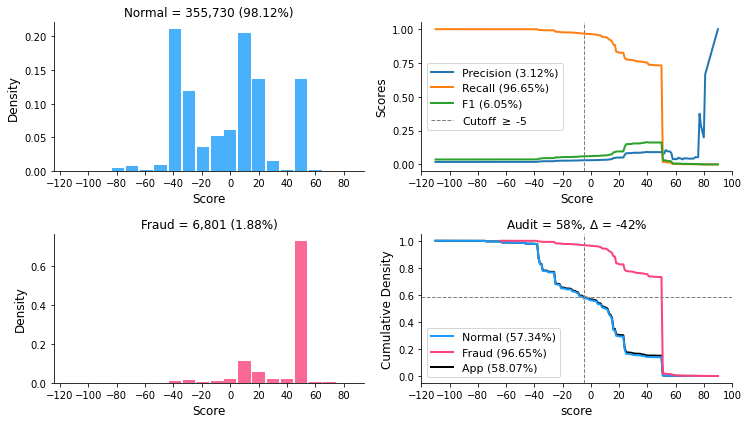

In [177]:
a = X_train[used_features].values
b = offset + (a*np.full(a.shape,scores)).sum(1)
plot_score(y_train, b, **kwargs)

## Test

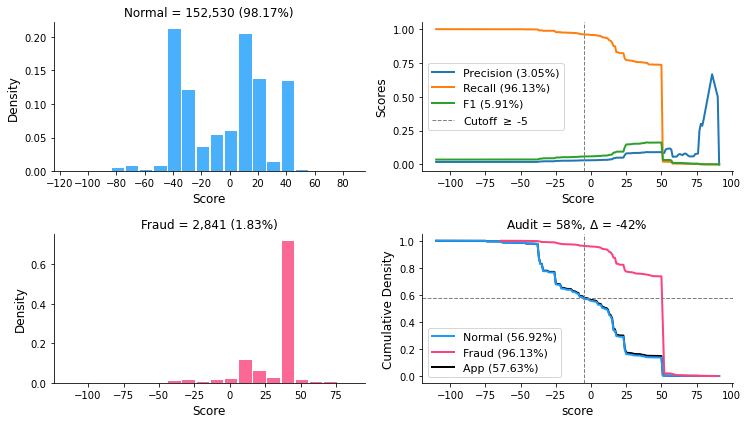

In [178]:
a = X_test[used_features].values
b = offset + (a*np.full(a.shape,scores)).sum(1)
plot_score(y_test, b, **kwargs)

## Out-Of-Time

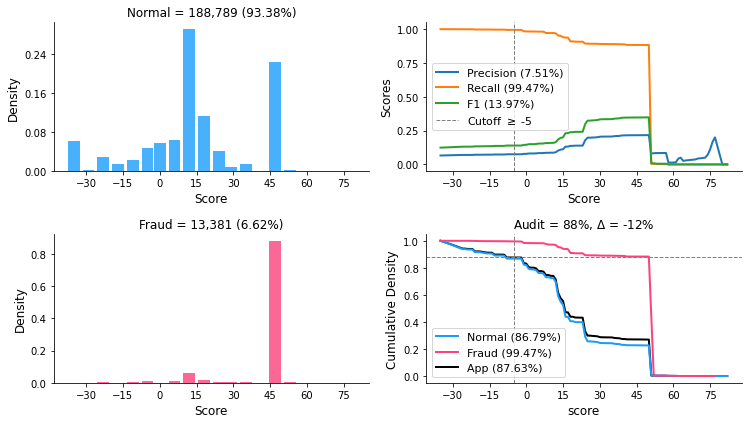

In [179]:
a = X_oot[used_features].values
b = offset + (a*np.full(a.shape,scores)).sum(1)
plot_score(y_oot, b, **kwargs)

## Summary

In [153]:
cutoff = -5

In [154]:
a = df[used_features].values
new_alert = (offset + (a*np.full(a.shape,scores)).sum(1)>=cutoff).astype(int)
old_alert = (a.sum(1)>0).astype(int)

In [155]:
c = df[["data_split","month_id","f_fraud"]].copy()
c["new_alert"] = new_alert
c["old_alert"] = old_alert
c["new_tp"] = np.where((new_alert==1) & (df["f_fraud"]==1),1,0)
c["new_fp"] = np.where((new_alert==1) & (df["f_fraud"]==0),1,0)
c["new_fn"] = np.where((new_alert==0) & (df["f_fraud"]==1),1,0)
c["old_tp"] = np.where((old_alert==1) & (df["f_fraud"]==1),1,0)
c["old_fp"] = np.where((old_alert==1) & (df["f_fraud"]==0),1,0)
c["old_fn"] = np.where((old_alert==0) & (df["f_fraud"]==1),1,0)

In [156]:
aggfnc = dict([("{}_{}".format(n,m),"sum") 
               for n in ["old","new"] 
               for m in ["alert","tp","fp","fn"]])
c = c.groupby(["month_id"]).agg(aggfnc)
for s in ["old","new"]:
    c[f"{s}_prec"]   = c[f"{s}_tp"]/(c[f"{s}_tp"] + c[f"{s}_fp"])
    c[f"{s}_recall"] = c[f"{s}_tp"]/(c[f"{s}_tp"] + c[f"{s}_fn"])
c["diff_alert"] = c["old_alert"] - c["new_alert"]
c["pct_diff_alert"] = c["diff_alert"] / c["old_alert"]

In [157]:
c.head()

,old_alert,old_tp,old_fp,old_fn,new_alert,new_tp,new_fp,new_fn,old_prec,old_recall,new_prec,new_recall,diff_alert,pct_diff_alert
month_id,,,,,,,,,,,,,,
2020-10,19479,220,19259,0,9243,178,9065,42,0.011294,1.0,0.019258,0.809091,10236,0.525489
2020-11,26632,249,26383,0,9988,196,9792,53,0.009350,1.0,0.019624,0.787149,16644,0.624962
2020-12,32580,295,32285,0,13485,264,13221,31,0.009055,1.0,0.019577,0.894915,19095,0.586096
2021-01,33031,198,32833,0,14831,178,14653,20,0.005994,1.0,0.012002,0.898990,18200,0.550998
2021-02,24575,129,24446,0,10483,119,10364,10,0.005249,1.0,0.011352,0.922481,14092,0.573428


In [158]:
labels = ["Existing 75 rules", "75 with scores"]
x = np.sort(pd.to_datetime(c.index, format="%Y-%m"))

## Precision

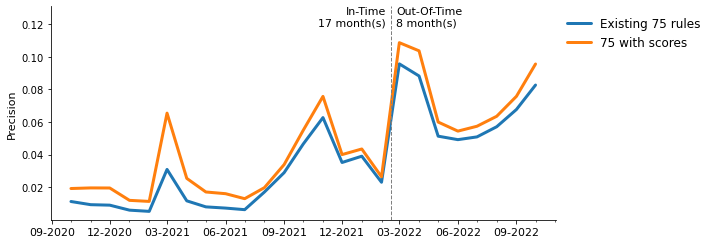

In [159]:
ax = plot_results(x, c["old_prec"], "Precision", labels, 17, y2=c["new_prec"])

## Recall

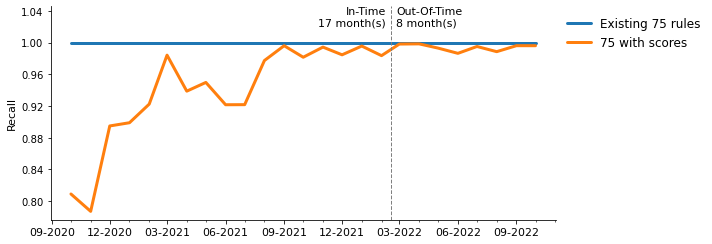

In [160]:
ax = plot_results(x, c["old_recall"], "Recall", labels, 17, y2=c["new_recall"])

## Number of alerts (in thousands)

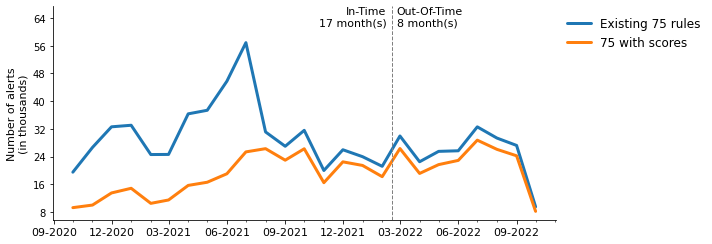

In [161]:
ax = plot_results(x, c["old_alert"]/1000, "Number of alerts\n(in thousands)", 
                  labels, 17, y2=c["new_alert"]/1000)

## Number of differences in alert (in thousands)

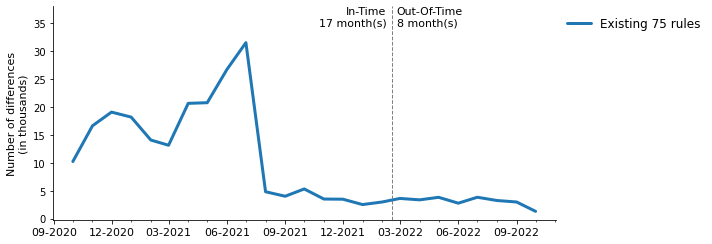

In [162]:
ax = plot_results(x, c["diff_alert"]/1000, "Number of differences\n(in thousands)", labels, 17)

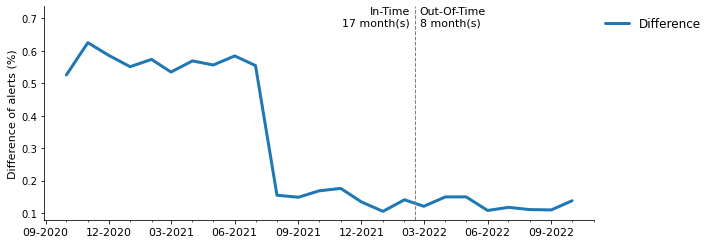

In [163]:
ax = plot_results(x, c["pct_diff_alert"], "Difference of alerts (%)", ["Difference"], 17)